In [1]:
import pandas as pd
import numpy as np
import pyunpack
import math
import json

from data.data_download import Config, download_electricity
from data_formatters.electricity import ElectricityFormatter
from data_formatters.base import DataTypes, InputTypes

from data.custom_dataset import TFTDataset
from models import GatedLinearUnit
from models import GateAddNormNetwork
from models import GatedResidualNetwork 
from models import ScaledDotProductAttention
from models import InterpretableMultiHeadAttention
from models import VariableSelectionNetwork

from quantile_loss import QuantileLossCalculator

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from argparse import ArgumentParser

import matplotlib.pyplot as plt

## Download Data

In [2]:
config = Config('data','data/electricity.csv')

In [3]:
download_electricity(config)

Pulling data from https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip to data/LD2011_2014.txt.zip
done
Unzipping file: data/LD2011_2014.txt.zip
Done.
Aggregating to hourly data
Processing MT_001
Processing MT_002
Processing MT_003
Processing MT_004
Processing MT_005
Processing MT_006
Processing MT_007
Processing MT_008
Processing MT_009
Processing MT_010
Processing MT_011
Processing MT_012
Processing MT_013
Processing MT_014
Processing MT_015
Processing MT_016
Processing MT_017
Processing MT_018
Processing MT_019
Processing MT_020
Processing MT_021
Processing MT_022
Processing MT_023
Processing MT_024
Processing MT_025
Processing MT_026
Processing MT_027
Processing MT_028
Processing MT_029
Processing MT_030
Processing MT_031
Processing MT_032
Processing MT_033
Processing MT_034
Processing MT_035
Processing MT_036
Processing MT_037
Processing MT_038
Processing MT_039
Processing MT_040
Processing MT_041
Processing MT_042
Processing MT_043
Processing MT_044

## Creating Datasets

In [4]:
electricity = pd.read_csv('data/electricity.csv', index_col = 0)
data_formatter = ElectricityFormatter()
train, valid, test = data_formatter.split_data(electricity)

/opt/conda/envs/nlp/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


## Loading Datasets

In [5]:
train_dataset = TFTDataset(train)
valid_dataset = TFTDataset(valid)
test_dataset = TFTDataset(test)

## Temporal Fusion Transformer

In [6]:
class TemporalFusionTransformer(pl.LightningModule):
    def __init__(self, params):
        super(TemporalFusionTransformer, self).__init__()
        
        self.hparams = params
        
        self.name = self.__class__.__name__

        # Data parameters
        self.time_steps = int(params.total_time_steps)#int(params['total_time_steps'])
        self.input_size = int(params.input_size)#int(params['input_size'])
        self.output_size = int(params.output_size)#int(params['output_size'])
        self.category_counts = json.loads(str(params.category_counts))#json.loads(str(params['category_counts']))
        self.num_categorical_variables = len(self.category_counts)
        self.num_regular_variables = self.input_size - self.num_categorical_variables
        self.n_multiprocessing_workers = int(params.multiprocessing_workers) #int(params['multiprocessing_workers'])

        # Relevant indices for TFT
        self._input_obs_loc = json.loads(str(params.input_obs_loc))#json.loads(str(params['input_obs_loc']))
        self._static_input_loc = json.loads(str(params.static_input_loc))#json.loads(str(params['static_input_loc']))
        self._known_regular_input_idx = json.loads(str(params.known_regular_inputs))#json.loads(str(params['known_regular_inputs']))
        self._known_categorical_input_idx = json.loads(str(params.known_categorical_inputs))#json.loads(str(params['known_categorical_inputs']))
        
        self.num_non_static_historical_inputs = self.get_historical_num_inputs()
        self.num_non_static_future_inputs = self.get_future_num_inputs()
        
        self.column_definition = [
                                  ('id', DataTypes.REAL_VALUED, InputTypes.ID),
                                  ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.TIME),
                                  ('power_usage', DataTypes.REAL_VALUED, InputTypes.TARGET),
                                  ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('day_of_week', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
                                ]

        # Network params
        self.quantiles = [0.1, 0.5, 0.9]
#         self.use_cudnn = use_cudnn  # Whether to use GPU optimised LSTM
        self.hidden_layer_size = int(params.hidden_layer_size)#int(params['hidden_layer_size'])
        self.dropout_rate = float(params.dropout_rate)#float(params['dropout_rate'])
        self.max_gradient_norm = float(params.max_gradient_norm)#float(params['max_gradient_norm'])
        self.learning_rate = float(params.learning_rate)#float(params['learning_rate'])
        self.minibatch_size = int(params.minibatch_size)#int(params['minibatch_size'])
        self.num_epochs = int(params.num_epochs)#int(params['num_epochs'])
        self.early_stopping_patience = int(params.early_stopping_patience)#int(params['early_stopping_patience'])

        self.num_encoder_steps = int(params.num_encoder_steps)#int(params['num_encoder_steps'])
        self.num_stacks = int(params.stack_size)#int(params['stack_size'])
        self.num_heads = int(params.num_heads)#int(params['num_heads'])

        # Serialisation options
#         self._temp_folder = os.path.join(params['model_folder'], 'tmp')
#         self.reset_temp_folder()

        # Extra components to store Tensorflow nodes for attention computations
        self._input_placeholder = None
        self._attention_components = None
        self._prediction_parts = None

        print('*** {} params ***'.format(self.name))
        for k in vars(hparams):
            print('# {} = {}'.format(k, vars(hparams)[k]))
            
        self.criterion = QuantileLossCalculator(self.quantiles, self.output_size)

        # Build model
        ## Build embeddings
        self.build_embeddings()
        
        ## Build Static Contex Networks
        self.build_static_context_networks()
        
        ## Building Variable Selection Networks
        self.build_variable_selection_networks()
        
        ## Build Lstm
        self.build_lstm()
        
        ## Build GLU for after lstm encoder decoder and layernorm
        self.build_post_lstm_gate_add_norm()
        
        ## Build Static Enrichment Layer
        self.build_static_enrichment()
        
        ## Building decoder multihead attention
        self.build_temporal_self_attention()
        
        ## Building positionwise decoder
        self.build_position_wise_feed_forward()
        
        ## Build output feed forward
        self.build_output_feed_forward()
        
        ## Initializing remaining weights
        self.init_weights()
        
    def init_weights(self):
        for name, p in self.named_parameters():
            if 'lstm' in name and 'bias' not in name:
                #print(name)
                #print(p.shape)
                torch.nn.init.xavier_normal_(p)
            elif 'lstm' in name and 'bias' in name:
                #print(name)
                #print(p.shape)
                torch.nn.init.zeros_(p)
        
    def get_historical_num_inputs(self):
        
        obs_inputs = [i for i in self._input_obs_loc]
        
        known_regular_inputs = [i for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
            
        known_categorical_inputs = [i for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]
        
        wired_embeddings = [i for i in range(self.num_categorical_variables)
                            if i not in self._known_categorical_input_idx 
                            and i not in self._input_obs_loc]

        unknown_inputs = [i for i in range(self.num_regular_variables)
                          if i not in self._known_regular_input_idx
                          and i not in self._input_obs_loc]

        return len(obs_inputs+known_regular_inputs+known_categorical_inputs+wired_embeddings+unknown_inputs)
    
    def get_future_num_inputs(self):
            
        known_regular_inputs = [i for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
            
        known_categorical_inputs = [i for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]

        return len(known_regular_inputs + known_categorical_inputs)
    
    def build_embeddings(self):
        self.categorical_var_embeddings = nn.ModuleList([nn.Embedding(self.category_counts[i], 
                                                                  self.hidden_layer_size) 
                                                     for i in range(self.num_categorical_variables)])

        self.regular_var_embeddings = nn.ModuleList([nn.Linear(1, 
                                                              self.hidden_layer_size) 
                                                  for i in range(self.num_regular_variables)])

    def build_variable_selection_networks(self):
        
        self.static_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size, 
                                                   output_size = len(self._static_input_loc),
                                                   dropout_rate = self.dropout_rate)
        
        self.temporal_historical_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                                input_size = self.hidden_layer_size *
                                                                        self.num_non_static_historical_inputs,
                                                                output_size = self.num_non_static_historical_inputs,
                                                                dropout_rate = self.dropout_rate,
                                                                additional_context=self.hidden_layer_size)
        
        self.temporal_future_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                            input_size = self.hidden_layer_size *
                                                                        self.num_non_static_future_inputs,
                                                            output_size = self.num_non_static_future_inputs,
                                                            dropout_rate = self.dropout_rate,
                                                            additional_context=self.hidden_layer_size)
        
    def build_static_context_networks(self):
        
        self.static_context_variable_selection_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                                          dropout_rate=self.dropout_rate)
        
        self.static_context_enrichment_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                              dropout_rate=self.dropout_rate)

        self.static_context_state_h_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                           dropout_rate=self.dropout_rate)
        
        self.static_context_state_c_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                           dropout_rate=self.dropout_rate)
        
    def build_lstm(self):
        self.historical_lstm = nn.LSTM(input_size = self.hidden_layer_size,
                                       hidden_size = self.hidden_layer_size,
                                       batch_first = True)
        self.future_lstm = nn.LSTM(input_size = self.hidden_layer_size,
                                   hidden_size = self.hidden_layer_size,
                                   batch_first = True)
        
    def build_post_lstm_gate_add_norm(self):
        self.post_seq_encoder_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                                 self.hidden_layer_size,
                                                                 self.dropout_rate,
                                                                 activation = None)
        
    def build_static_enrichment(self):
        self.static_enrichment = GatedResidualNetwork(self.hidden_layer_size,
                                                      dropout_rate = self.dropout_rate,
                                                      additional_context=self.hidden_layer_size)
        
    def build_temporal_self_attention(self):
        self.self_attn_layer = InterpretableMultiHeadAttention(n_head = self.num_heads, 
                                                               d_model = self.hidden_layer_size,
                                                               dropout = self.dropout_rate)
        
        self.post_attn_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                           self.hidden_layer_size,
                                                           self.dropout_rate,
                                                           activation = None)
        
    def build_position_wise_feed_forward(self):
        self.GRN_positionwise = GatedResidualNetwork(self.hidden_layer_size,
                                                     dropout_rate = self.dropout_rate)
        
        self.post_tfd_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                         self.hidden_layer_size,
                                                         self.dropout_rate,
                                                         activation = None)
        
    def build_output_feed_forward(self):
        self.output_feed_forward = torch.nn.Linear(self.hidden_layer_size, 
                                                   self.output_size * len(self.quantiles))
         
    def get_decoder_mask(self, self_attn_inputs):
        """Returns causal mask to apply for self-attention layer.
        Args:
        self_attn_inputs: Inputs to self attention layer to determine mask shape
        """
        len_s = self_attn_inputs.shape[1]
        bs = self_attn_inputs.shape[0]
        mask = torch.cumsum(torch.eye(len_s), 0)
        mask = mask.repeat(bs,1,1).to(torch.float32)

        return mask.to(DEVICE)
    
    def get_tft_embeddings(self, regular_inputs, categorical_inputs):
        # Static input
        if self._static_input_loc:
            static_regular_inputs = [self.regular_var_embeddings[i](regular_inputs[:, 0, i:i + 1]) 
                                    for i in range(self.num_regular_variables)
                                    if i in self._static_input_loc]
            #print('static_regular_inputs')
            #print([print(emb.shape) for emb in static_regular_inputs])
            
            static_categorical_inputs = [self.categorical_var_embeddings[i](categorical_inputs[Ellipsis, i])[:,0,:] 
                                         for i in range(self.num_categorical_variables)
                                         if i + self.num_regular_variables in self._static_input_loc]
            #print('static_categorical_inputs')
            #print([print(emb.shape) for emb in static_categorical_inputs])
            static_inputs = torch.stack(static_regular_inputs + static_categorical_inputs, axis = 1)
        else:
            static_inputs = None
            
        # Target input
        obs_inputs = torch.stack([self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                                     for i in self._input_obs_loc], axis=-1)
        
        # Observed (a prioir unknown) inputs
        wired_embeddings = []
        for i in range(self.num_categorical_variables):
            if i not in self._known_categorical_input_idx \
            and i not in self._input_obs_loc:
                e = embeddings[i](categorical_inputs[:, :, i])
                wired_embeddings.append(e)

        unknown_inputs = []
        for i in range(regular_inputs.shape[-1]):
            if i not in self._known_regular_input_idx \
            and i not in self._input_obs_loc:
                e = convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
                unknown_inputs.append(e)
                
        if unknown_inputs + wired_embeddings:
            unknown_inputs = torch.stack(unknown_inputs + wired_embeddings, axis=-1)
        else:
            unknown_inputs = None
            
        # A priori known inputs
        known_regular_inputs = [self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                                for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
        #print('known_regular_inputs')
        #print([print(emb.shape) for emb in known_regular_inputs])
        
        known_categorical_inputs = [self.categorical_var_embeddings[i](categorical_inputs[Ellipsis, i])
                                    for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]
       #print('known_categorical_inputs')
       #print([print(emb.shape) for emb in known_categorical_inputs])

        known_combined_layer = torch.stack(known_regular_inputs + known_categorical_inputs, axis=-1)
        
        return unknown_inputs, known_combined_layer, obs_inputs, static_inputs
        
    def forward(self, all_inputs):

        regular_inputs = all_inputs[:, :, :self.num_regular_variables].to(torch.float)
        categorical_inputs = all_inputs[:, :, self.num_regular_variables:].to(torch.long)
        
        unknown_inputs, known_combined_layer, obs_inputs, static_inputs \
            = self.get_tft_embeddings(regular_inputs, categorical_inputs)
        
        # Isolate known and observed historical inputs.
        if unknown_inputs is not None:
              historical_inputs = torch.cat([
                  unknown_inputs[:, :self.num_encoder_steps, :],
                  known_combined_layer[:, :self.num_encoder_steps, :],
                  obs_inputs[:, :self.num_encoder_steps, :]
              ], axis=-1)
        else:
              historical_inputs = torch.cat([
                  known_combined_layer[:, :self.num_encoder_steps, :],
                  obs_inputs[:, :self.num_encoder_steps, :]
              ], axis=-1)
                
        #print('historical_inputs')
        #print(historical_inputs.shape)
        
        # Isolate only known future inputs.
        future_inputs = known_combined_layer[:, self.num_encoder_steps:, :]
        #print('future_inputs')
        #print(future_inputs.shape)
              
        #print('static_inputs')
        #print(static_inputs.shape)
        
        static_encoder, sparse_weights = self.static_vsn(static_inputs)
        
        #print('static_encoder')
        #print(static_encoder.shape)
        
        #print('sparse_weights')
        #print(sparse_weights.shape)
        
        static_context_variable_selection = self.static_context_variable_selection_grn(static_encoder)
        #print('static_context_variable_selection')
        #print(static_context_variable_selection.shape)
        static_context_enrichment = self.static_context_enrichment_grn(static_encoder)
        #print('static_context_enrichment')
        #print(static_context_enrichment.shape)
        static_context_state_h = self.static_context_state_h_grn(static_encoder)
        #print('static_context_state_h')
        #print(static_context_state_h.shape)
        static_context_state_c = self.static_context_state_c_grn(static_encoder)
        #print('static_context_state_c')
        #print(static_context_state_c.shape)
        
        historical_features, historical_flags \
        = self.temporal_historical_vsn((historical_inputs,
                                        static_context_variable_selection))
        #print('historical_features')
        #print(historical_features.shape)
        #print('historical_flags')
        #print(historical_flags.shape)
        
        future_features, future_flags \
        = self.temporal_future_vsn((future_inputs,
                                    static_context_variable_selection))
        #print('future_features')
        #print(future_features.shape)
        #print('future_flags')
        #print(future_flags.shape)
        
        history_lstm, (state_h, state_c) \
        = self.historical_lstm(historical_features,
                               (static_context_state_h.unsqueeze(0),
                                static_context_state_c.unsqueeze(0)))
        #print('history_lstm')
        #print(history_lstm.shape)
        #print('state_h')
        #print(state_h.shape)
        #print('state_c')
        #print(state_c.shape)
        
        future_lstm, _ = self.future_lstm(future_features,
                                          (state_h,
                                           state_c))
        #print('future_lstm')
        #print(future_lstm.shape)
        
        # Apply gated skip connection
        input_embeddings = torch.cat((historical_features, future_features), axis=1)
        #print('input_embeddings')
        #print(input_embeddings.shape) 
        
        lstm_layer = torch.cat((history_lstm, future_lstm), axis=1)
        #print('lstm_layer')
        #print(lstm_layer.shape) 
        
        temporal_feature_layer = self.post_seq_encoder_gate_add_norm(lstm_layer, input_embeddings)
        #print('temporal_feature_layer')
        #print(temporal_feature_layer.shape)  
        
        # Static enrichment layers
        expanded_static_context = static_context_enrichment.unsqueeze(1)
        
        enriched = self.static_enrichment((temporal_feature_layer, expanded_static_context))
        #print('enriched')
        #print(enriched.shape)    
        
        # Decoder self attention
        x, self_att = self.self_attn_layer(enriched, 
                                           enriched, 
                                           enriched,
                                           mask = self.get_decoder_mask(enriched))
        #print('x')
        #print(x.shape)
        #print('self_att')
        #print(self_att.shape)
        
        x = self.post_attn_gate_add_norm(x, enriched)
        #print('x')
        #print(x.shape)
        
        # Nonlinear processing on outputs
        decoder = self.GRN_positionwise(x)
        #print('decoder')
        #print(decoder.shape)
        
        # Final skip connection
        transformer_layer = self.post_tfd_gate_add_norm(decoder, temporal_feature_layer)
        #print('transformer_layer')
        #print(transformer_layer.shape)
        
        outputs = self.output_feed_forward(transformer_layer[Ellipsis, self.num_encoder_steps:, :])
        #print('outputs')
        #print(outputs.shape)
        
        #ipdb.set_trace()
        
        return outputs
    
    def loss(self, y_hat, y):
        return self.criterion.apply(y_hat, y)
    
    def training_step(self, batch, batch_nb):
        x, y, _ = batch
        
        x = x.to(torch.float)
        y = y.to(torch.float)
        
        y_hat = self.forward(x)
        #print(y_hat.shape)
        loss = self.loss(y_hat, torch.cat([y, y, y], dim = -1))
        #print(loss.shape)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_nb):
        x, y, _ = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        #print(y_hat.shape)
        #print(torch.cat([y, y, y], dim = -1).shape)
        loss = self.loss(y_hat, torch.cat([y, y, y], dim = -1))
        #print(loss)
        return {'val_loss': loss}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y, _ = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        return {'test_loss': self.loss(y_hat, torch.cat([y, y, y], dim = -1))}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return [torch.optim.Adam(self.parameters(), lr=self.learning_rate)]#self.learning_rate)]
    
    def plot_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for name, p in named_parameters:
            if p.grad is not None:
                if (p.requires_grad) and ("bias" not in name):
                    layers.append(name)
                    ave_grads.append(p.grad.abs().mean())
                    self.logger.experiment.add_histogram(tag=name, values=p.grad,
                                                         global_step=self.trainer.global_step)
            else:
                 print('{} - {}'.format(name, p.requires_grad))
            
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads), linewidth=1, color="k" )
        plt.xticks(list(range(0,len(ave_grads), 1)), layers, rotation='vertical')
        plt.xlim(left=0, right=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.rcParams["figure.figsize"] = (20, 3)
    
    def on_after_backward(self):
        #print('applied backward')
        # example to inspect gradient information in tensorboard
        if self.trainer.global_step % 25 == 0:  
            self.plot_grad_flow(self.named_parameters())
    
    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(train_dataset, batch_size = self.minibatch_size, shuffle=True, drop_last=True)

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(valid_dataset, batch_size = self.minibatch_size, shuffle=True, drop_last=True)
    
    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(test_dataset, batch_size = self.minibatch_size, shuffle=True, drop_last=True)

/opt/conda/envs/nlp/lib/python3.7/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning: data_loader decorator deprecated in 0.7.0. Will remove 0.9.0
  warnings.warn(w)


## Training

In [7]:
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [8]:
params = data_formatter.get_experiment_params()
params.update(data_formatter.get_default_model_params())

parser = ArgumentParser(add_help=False)

In [9]:
for k in params:
    if type(params[k]) in [int, float]:
        parser.add_argument('--{}'.format(k), type=type(params[k]), default = params[k])
    else:
        parser.add_argument('--{}'.format(k), type=str, default = str(params[k]))
hparams = parser.parse_known_args()[0]

In [10]:
tft = TemporalFusionTransformer(hparams)#.to(DEVICE)
tft

*** TemporalFusionTransformer params ***
# total_time_steps = 192
# num_encoder_steps = 168
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('power_usage', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('hour', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('day_of_week', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('categorical_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)]
# input_size = 5
# output_size = 1
# category_counts = [369]
# input_obs_loc = [0]
# static_input_loc = [4]
# known_regular_inputs = [1, 2, 3]
# known_categorical_inputs = [0]
# dropout_rate = 0.1
# hidden_layer_size = 160
# learning_rate = 0.001
# minibatch_size = 64
# max_gradient_norm = 0.01
# num_heads = 4

TemporalFusionTransformer(
  (categorical_var_embeddings): ModuleList(
    (0): Embedding(369, 160)
  )
  (regular_var_embeddings): ModuleList(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): Linear(in_features=1, out_features=160, bias=True)
    (2): Linear(in_features=1, out_features=160, bias=True)
    (3): Linear(in_features=1, out_features=160, bias=True)
  )
  (static_context_variable_selection_grn): GatedResidualNetwork(
    (W1): Linear(in_features=160, out_features=160, bias=True)
    (W2): Linear(in_features=160, out_features=160, bias=True)
    (glu_add_norm): GateAddNormNetwork(
      (GLU): GatedLinearUnit(
        (dropout): Dropout(p=0.1, inplace=False)
        (W4): Linear(in_features=160, out_features=160, bias=True)
        (W5): Linear(in_features=160, out_features=160, bias=True)
        (activation): Sigmoid()
      )
      (LayerNorm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
  )
  (static_context_enrichment_grn): GatedResid

In [11]:
early_stop_callback = EarlyStopping(monitor = 'val_loss',
                                    min_delta = 1e-4,
                                    patience = tft.early_stopping_patience,
                                    verbose=False,
                                    mode='min')

1

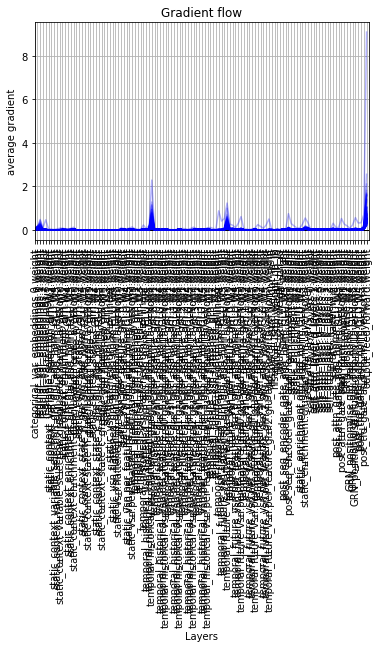

In [12]:
trainer = pl.Trainer(max_nb_epochs = tft.num_epochs,
                     gpus = [0], 
                     track_grad_norm = 2, 
                     gradient_clip_val = tft.max_gradient_norm,
                     early_stop_callback = early_stop_callback,
                     #train_percent_check = 0.01,
                     overfit_pct=0.01,
                     #fast_dev_run=True,
                     profiler=True,
                     print_nan_grads = True
                    )    
trainer.fit(tft)